# 利用机器学习模型针对多维特征进行多模型比较、模型调优

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression,Ridge,ElasticNet
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 数据预处理

In [2]:
# 获取数据
hft_data = pd.read_csv('HFT_XY_unselected.csv',index_col=0)
hft_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X325,X326,X327,X328,X329,X330,X331,X332,realY,predictY
0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,4.506952,-0.0,...,4.139076,3.443876,6.085272,4.589867,-2.979077,-6.393372,-4.417067,-4.611922,-0.000000,0.0
1,-0.0,-0.0,-0.0,0.551516,1.103168,-0.0,-0.949546,-0.0,-0.000000,-0.0,...,4.151743,4.566135,6.904618,3.911805,-4.863125,-9.709144,-3.535746,-3.946805,1.199756,0.0
2,-0.0,-0.0,-0.0,0.874133,0.753029,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,4.139076,4.062686,8.037572,4.589867,-3.737310,-7.461474,-4.846605,-5.060409,-0.516707,0.0
3,-0.0,-0.0,-0.0,-0.874133,0.475108,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,4.139076,4.031714,7.738847,4.589867,-3.202318,-8.799307,-3.505467,-4.390713,-0.000000,0.0
4,-0.0,-0.0,-0.0,-0.874133,1.333798,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,4.151743,3.638764,6.904618,3.911805,-4.063161,-9.709144,-4.418497,-4.613416,1.033414,0.0


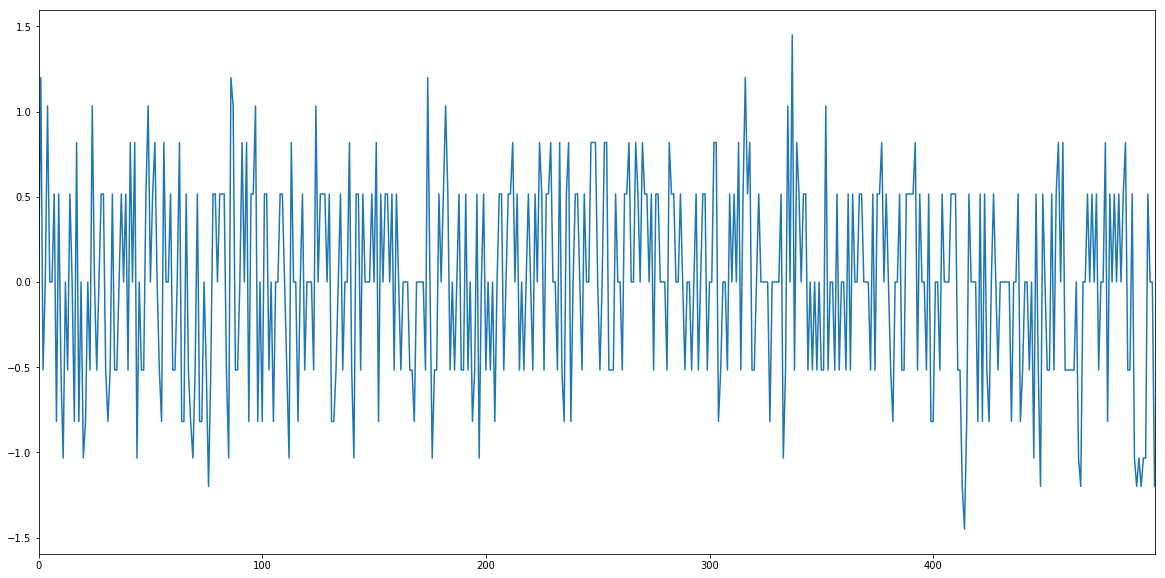

In [3]:
# 目标数据可视化，通过分析以后便于模型选择
%matplotlib inline
hft_data['realY'][:500].plot(figsize=(20,10))

In [4]:
# 获取输入数据集和目标数据集
X = hft_data.copy().drop(['realY','predictY'],axis=1)
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332
0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,4.506952,-0.0,...,5.015210,6.373491,4.139076,3.443876,6.085272,4.589867,-2.979077,-6.393372,-4.417067,-4.611922
1,-0.0,-0.0,-0.0,0.551516,1.103168,-0.0,-0.949546,-0.0,-0.000000,-0.0,...,5.549555,6.781841,4.151743,4.566135,6.904618,3.911805,-4.863125,-9.709144,-3.535746,-3.946805
2,-0.0,-0.0,-0.0,0.874133,0.753029,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,2.510038,5.970988,4.139076,4.062686,8.037572,4.589867,-3.737310,-7.461474,-4.846605,-5.060409
3,-0.0,-0.0,-0.0,-0.874133,0.475108,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,4.759310,6.812667,4.139076,4.031714,7.738847,4.589867,-3.202318,-8.799307,-3.505467,-4.390713
4,-0.0,-0.0,-0.0,-0.874133,1.333798,-0.0,-0.000000,-0.0,-0.000000,-0.0,...,3.554940,6.781841,4.151743,3.638764,6.904618,3.911805,-4.063161,-9.709144,-4.418497,-4.613416


In [5]:
y = hft_data.copy()['realY']
y.head()

0   -0.000000
1    1.199756
2   -0.516707
3   -0.000000
4    1.033414
Name: realY, dtype: float64

In [6]:
print X.shape,y.shape

(241032, 332) (241032L,)


In [7]:
# 构建训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
print X_train.shape,X_test.shape,y_train.shape,y_test.shape

(168722, 332) (72310, 332) (168722L,) (72310L,)


In [8]:
# 特征标准化
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print X_train[:50],X_test[:10]

[[ -3.60621969e+00  -1.94304105e+00  -1.27949749e+00 ...,   7.99391082e-02
    1.45330665e-02   8.13952917e-01]
 [  4.28231927e-05   3.07333344e+00  -2.55865393e-03 ...,  -9.97732030e-01
    1.89173414e+00  -6.90521663e-01]
 [  4.28231927e-05  -2.44249762e-03  -2.55865393e-03 ...,   2.97573657e-01
   -3.65783586e-01   3.17807802e-01]
 ..., 
 [  4.28231927e-05  -2.44249762e-03  -2.55865393e-03 ...,   4.84514579e-01
    5.63425233e-01   2.56596055e-01]
 [  4.28231927e-05  -2.44249762e-03  -2.55865393e-03 ...,  -1.85346363e+00
   -9.92996618e-02   6.65451525e-01]
 [  4.28231927e-05   3.07333344e+00   2.02134152e+00 ...,  -1.34941684e+00
   -1.70909118e+00  -1.43461480e+00]] [[  4.28231927e-05  -2.44249762e-03  -2.55865393e-03 ...,  -9.83396758e-01
    2.43182190e+00   6.65451525e-01]
 [  4.28231927e-05  -2.44249762e-03  -2.55865393e-03 ...,   3.63776536e-01
   -5.21164922e-01  -1.85899534e-01]
 [  4.28231927e-05  -2.44249762e-03  -2.02645883e+00 ...,   1.73696936e+00
   -2.24795917e-01  -

## 模型应用

In [9]:
# 首先尝试最简单的线性回归模型
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test,y_pred)
print 'LinearRegression R2 Score:',score

LinearRegression R2 Score: 0.0659164590551


In [10]:
# 从sk-learn找其他回归模型进行尝试
models = [('ElasticNet',ElasticNet()),
          ('Ridge',Ridge()),
          ('RandomForestRegressor',RandomForestRegressor(n_estimators=1000,max_features='log2'))
         ]
for m in models:
    m[1].fit(X_train,y_train)
    y_pred = m[1].predict(X_test)
    score = r2_score(y_test,y_pred)
    print m[0]+' Score:',score

ElasticNet Score: -4.86632209196e-06
Ridge Score: 0.0659200645809
RandomForestRegressor Score: 0.0656231526017


### 针对r2_sorce为负的情况，表明模型构建的非常不成功，这里是考察经验的最重要的点

### 模型选择和调优

In [13]:
# 根据上面的结果，可以对LinearRegression以及Ridge进行进一步的参数调优
tuned_parameters = [{'alpha':[1.0,0.8,0.1,0.01,0.001]}]
model = GridSearchCV(Ridge(),tuned_parameters,cv=10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test,y_pred)
print 'Tuned Ridge R2 Score:',score

Tuned Ridge R2 Score: 0.0659200645809


### 以上步骤是一个初学者的标准步骤，有经验的人会针对目标数据进行分析，决定选择什么样的初始化模型，而不是撞大运似的寻找模型。

## 模型集成，对优化后的模型进一步调优

In [ ]:
# 对可用模型进行进一步的集成，方法为stacking,blending,bagging(adaboost)